## Tutorial with the Diva synthesizer controlled with Dynamical Movement Primitives

This tutorials shows how to run an agent learning to produce sound trajectories with a simulated vocal tract, through autonomous exploration and imitation.

Requirements:
- Explauto
- DIVA
- Matlab and [pymatlab](http://pymatlab.sourceforge.net/), or Octave and [oct2py](https://pypi.python.org/pypi/oct2py)
- pyaudio

DIVA is a neural model of speech acquisition and production that accounts for a wide range of acoustic, kinematic,
and neuroimaging data concerning the control of speech movements, as describe on [this page](http://sites.bu.edu/guentherlab/research-projects/the-diva-model-of-speech-motor-control/). The code of the model is open-source and is avaible [here](http://sites.bu.edu/guentherlab/software/diva-source-code/). You will have to download and unzip it to run this tutorial. 
The DIVA model uses an [articulatory synthesizer](http://en.wikipedia.org/wiki/Articulatory_synthesis), i.e. a computer simulation of the human vocal tract allowing to generate the sound wave resulting from articulator movements involving the jaw, the tongue, the lips ... This is this articulatory synthesizer that we will use, independently of the neural model. For more information please refer to the documentation in the pdf provided in the DIVA zip archive.
Also, if using Matlab, it needs to be aware of your DIVA installation path (i.e. the path of the unzipped DIVA directory). You will have to add it by [editing your search path](http://fr.mathworks.com/help/matlab/matlab_env/add-remove-or-reorder-folders-on-the-search-path.html) permanently.


Content:
- I. Setting up a Diva Environment
- II. Generating sound trajectories with Dynamical Movement Primitives
- III. Goal Babbling
- IV. Imitation

The four parts are code-independent in the sense that you can restart your kernel and run code from any part, you don't need to rerun from the beginning.

## I. Setting up a Diva Environment

The DIVA synthesizer takes 13 articulatory positions and returns the formants of the corresponding sound (F0 to F4). For example, the first articulator globally corresponds to an open/close dimension mainly involving the jaw, as shown in the figure below extracted from the DIVA documentation (the pdf in the zip archive). It illustrates the movements induced by the 10 first articulators (left to right, top to bottom), the 3 last ones controlling the pitch, the pressure and the voicing (see the DIVA documentation for more details). All articulatory positions should be in the range $[-1, 1]$.

![Alt text](diva_arts.png)

Let's define a first Explauto environment that contains the DIVA synthesizer. If you use Matlab, don't forget to tell him where is your installation of DIVA, and then specify synth="matlab" in the following. If using Octave, specify the diva_path and synth="octave".

In [1]:
from __future__ import print_function

import os
import numpy as np
from explauto.environment.diva import DivaEnvironment

diva_cfg = dict(diva_path=os.path.join(os.getenv("HOME"), 'software/DIVAsimulink/'),
                synth="octave",
                m_mins = np.array([-1]*7), # motor bounds
                m_maxs = np.array([1]*7),
                s_mins = np.array([ 7.5,  9.25]), # sensory bounds
                s_maxs = np.array([ 9.5 ,  11.25]),
                m_used = range(7), # articulatory parameters used from 0 to 9
                s_used = range(1, 3), # formants output from F0 to F3
                audio = True) # if sound is played

environment = DivaEnvironment(**diva_cfg)

The diva configuration (diva_cfg) can be modified. For instance, here only 7 of the 10 articulatory parameters are used (the 7 most important) and the 3 others are set to 0, but you can use 10 instead of 7 parameters. Also, DIVA outputs F0 (pitch), F1, F2 and F3 but here the environment will output only F1 and F2 because we set s_used = [1, 2]. We also defined the motor bounds [-1, 1] and the sensory bounds of F1 and F2 in octaves (or log2(Hz)): e.g. the environment will always output F1 between 7.5 and 9.5.

### Random sounds

If your installation of DIVA and explauto are working well, you should now be able to produce some sounds with random articulatory positions:

(1200.0, 200.0)

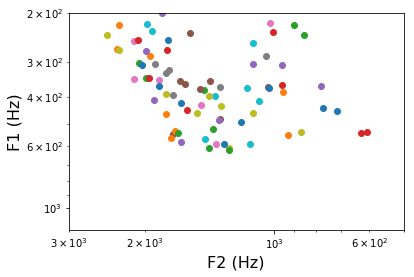

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

for m in environment.random_motors(100):
    #print m
    formants = environment.update(m)
    #print formants
    plt.loglog(2.**formants[1], 2.**formants[0], 'o')


plt.xlabel("F2 (Hz)", fontsize=16)
plt.ylabel("F1 (Hz)", fontsize=16)
plt.xlim([3000., 500])
plt.ylim([1200., 200.])

The DIVAEnvironment outputs the frequency of the first and second formants (F1 and F2) in octaves - or log2(Hz) - but here we plot their frequencies in Hz, with the axes reversed and F2 on the x axis as in Praat conventions. Each dot is one sound produced with a random articulatory position (and you should have heard them if you enabled audio and turned sound on.

### Trajectory of sounds

The Diva Environment can also take a trajectory of sounds as input and will then output the trajectory of the corresponding formants. Here we define an articulatory trajectory where only the first articulator (the jaw) moves, from 1 to -1. We also plot the trajectory in formant space.

(1200.0, 200.0)

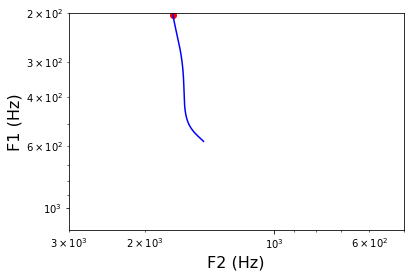

In [3]:
m_traj = np.zeros((1000, 7))
m_traj[:, 0] = np.linspace(1, -1, 1000) # The jaw moves linearly for 1 (completely close) to -1 (completely open)

s = environment.update(m_traj)

plt.loglog(2.**s[0][1], 2.**s[0][0], "ro") # Start: red dot
plt.loglog([2.**formants[1] for formants in s], [2.**formants[0] for formants in s], 'b-')


plt.xlabel("F2 (Hz)", fontsize=16)
plt.ylabel("F1 (Hz)", fontsize=16)
plt.xlim([3000., 500])
plt.ylim([1200., 200.])

Let's listen to the sound trajectory:

In [4]:
import IPython
IPython.display.Audio(environment.sound_wave(environment.art_traj).flatten(), rate=11025)

## II. Generating sound trajectories with Dynamical Movement Primitives

In order to define an arbitrary trajectory of the 7 articulators for n time steps, we would need 7 x n values. However, if we consider that a realistic vocal tract cannot produce a trajectory with quick discontinuities, so we could use a representation of trajectories with less degrees of freedom. Also, a compact representation of sound trajectories will make learning by an agent easier. The Dynamical Movement Primitives (DMPs) framework allows to represent smooth trajectories with few parameters. See [here](https://studywolf.wordpress.com/2013/11/16/dynamic-movement-primitives-part-1-the-basics/) for a nice tutorial on DMPs. In this framework, each of the 7 articulators position will be parameterized by the starting and ending point of the trajectory plus one parameter on each basis function to modify the trajectory from the starting point to the end.

In [5]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from explauto.environment.diva import DivaDMPEnvironment

diva_cfg = dict(diva_path=os.path.join(os.getenv("HOME"), 'software/DIVAsimulink/'),
                synth="octave",
                m_mins = np.array([-1] * 28),
                m_maxs = np.array([1] * 28),
                s_mins = np.array([7.5]*10 + [9.25]*10),
                s_maxs = np.array([9.5]*10 + [11.25]*10),
                m_used = range(7),
                s_used = range(1, 3),
                n_dmps = 7, # parameters controlled by DMPs
                n_bfs = 2, # basis functions
                dmp_move_steps = 50, # trajectory time steps 
                dmp_max_param = 300., # max value of the weights on basis functions
                sensory_traj_samples = 10, # samples of the formant trajectory to output
                audio = True)

environment = DivaDMPEnvironment(**diva_cfg)

Here we defined a Diva Environment with articulators trajectories generated through DMPs. We designed DMPs with 2 basis functions so that each articulator has 4 parameters: the starting and end position plus 2 weights for the basis functions. The total number of parameters is thus 7 x 4 = 28.

Given a set of 28 motor parameters, the environment outputs a formant trajectory (with 'sensory_traj_samples' time steps).

In the following we generate 28 random parameters that we feed to the environment which computes a trajectory of the 7 articulators (through DMPds), and then the correponding formant trajectory (through DIVA). We first plot the articulators trajectory generated through DMPs:

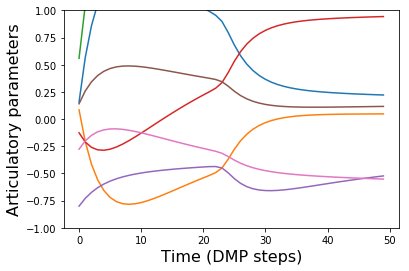

In [6]:
m = environment.random_motors()[0]
s = environment.update(m)

traj = environment.trajectory(m)
plt.plot(traj)

plt.ylim([-1., 1.])
plt.xlabel("Time (DMP steps)", fontsize=16)
plt.ylabel("Articulatory parameters", fontsize=16)

's' contains the 10-steps trajectory of the two formants. We plot this trajectory along with some vowels:

s [7.5991565484016919, 7.6494545876702755, 7.3853619127719208, 7.2337117004198781, 7.3091239768895031, 7.834287880233207, 8.0740746370097085, 8.158727668252741, 8.1990164056478054, 8.2250716721304276, 10.951157994477452, 10.95185630742394, 10.976002563087922, 10.991712854258902, 10.978078494223155, 10.904093554230844, 10.864241929671396, 10.848462518751733, 10.840777285749372, 10.835810055134099]


(1200.0, 200.0)

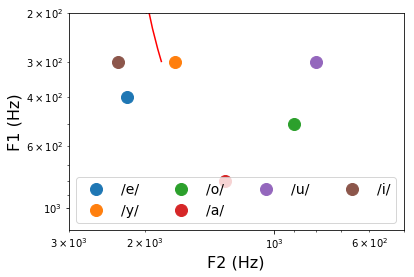

In [7]:
print("s", s)

plt.loglog([2.**f for f in s[len(s)//2:]], [2.**f for f in s[:len(s)//2]], color="r")

# Plot some vowels
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
v_a = list(np.log2([800, 1300]))
vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i, a=v_a)
for v in vowels.keys():
    p = plt.plot(2.**vowels[v][1], 2.**vowels[v][0], "o", label="/" + v + "/", markersize=12)

legend = plt.legend(frameon=True, fontsize=14, ncol=4, loc="lower center")

plt.xlabel("F2 (Hz)", fontsize=16)
plt.ylabel("F1 (Hz)", fontsize=16)
plt.xlim([3000., 500])
plt.ylim([1200., 200.])

To have a closer look at DMPs, we can plot the shape of the two basis functions that are used to generate a trajectory of an articulator given one weight on each basis function plus the start and end position of the articulator.

centers: [ 0.69314718  0.22314355]
variances: [  55.45130697  303.58021728]


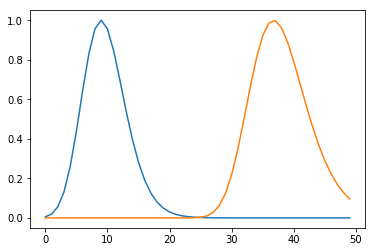

In [8]:
print("centers:", environment.dmp.dmp.c)
print("variances:", environment.dmp.dmp.h)
bfs_shapes = environment.dmp.dmp.gen_psi(environment.dmp.dmp.cs.rollout())
plt.plot(bfs_shapes)

Here is the sound trajectory generated with the random set of parameters:

In [9]:
import IPython
IPython.display.Audio(environment.sound_wave(environment.art_traj).flatten(), rate=11025)

And now we plot 20 trajectories generated with random DMP parameters.

/home/sforesti/scm/Flowers/explauto/build/lib/explauto/environment/diva/diva.py:152: RuntimeWarning: invalid value encountered in log2
  formants = log2(transpose(res[self.s_used,:]))


(1200.0, 200.0)

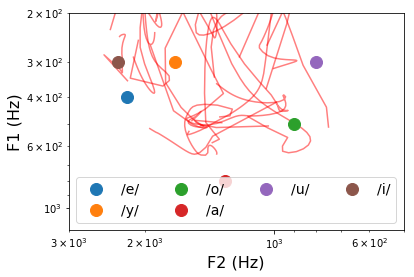

In [10]:
for m in environment.random_motors(20):
    s = environment.update(m)
    plt.loglog([2.**f[1] for f in environment.formants_traj], [2.**f[0] for f in environment.formants_traj], color="r", alpha=0.5)

# Plot some vowels
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
v_a = list(np.log2([800, 1300]))
vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i, a=v_a)
for v in vowels.keys():
    p = plt.plot(2.**vowels[v][1], 2.**vowels[v][0], "o", label="/" + v + "/", markersize=12)

legend = plt.legend(frameon=True, fontsize=14, ncol=4, loc="lower center")

plt.xlabel("F2 (Hz)", fontsize=16)
plt.ylabel("F1 (Hz)", fontsize=16)
plt.xlim([3000., 500])
plt.ylim([1200., 200.])

## III. Goal Babbling

In this section we run an experiment where an agent explores with the random goal babbling (GB) strategy. 
See this [tutorial](http://nbviewer.jupyter.org/github/sebastien-forestier/ExplorationAlgorithms/blob/master/main.ipynb) for a comparison of different exploration strategies in a setup with a simulated robotic arm grasping a ball.
An agent with a goal babbling exploration strategy chooses a new goal at each exploration iteration, the goal being a target in its observation space. Here, the agent controls DMP parameters and observes formant trajectories. It will thus generates goal formant trajectories, and try to reach those trajectories (produce the sound trajectories) given its current sensorimotor model.

In [11]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from explauto.environment.diva import DivaDMPEnvironment
from explauto.sensorimotor_model.non_parametric import NonParametric
from explauto.utils import rand_bounds

diva_cfg = dict(diva_path=os.path.join(os.getenv("HOME"), 'software/DIVAsimulink/'),
                synth="octave",
                m_mins = np.array([-1] * 28),
                m_maxs = np.array([1] * 28),
                s_mins = np.array([7.5]*10 + [9.25]*10),
                s_maxs = np.array([9.5]*10 + [11.25]*10),
                m_used = range(7),
                s_used = range(1, 3),
                n_dmps = 7, # parameters controlled by DMPs
                n_bfs = 2, # basis functions
                dmp_move_steps = 50, # trajectory time steps 
                dmp_max_param = 300., # max value of the weights on basis functions
                sensory_traj_samples = 10, # samples of the formant trajectory to output
                audio = True)

environment = DivaDMPEnvironment(**diva_cfg)

We define the sensorimotor with the Nearest Neighbor algorithm (NN). Given a target s_goal, the model infers a motor command (DMP parameters) m that could help to reach s_goal. To do so, it looks at the previous observed formant trajectory s_NN that is the closest to s_goal, and outputs the motor command m that was used to reach s_NN plus some exploration noise to explore new motor commands (Gaussian of standard deviation sigma_explo_ratio). See [here](http://nbviewer.jupyter.org/github/flowersteam/explauto/blob/master/notebook/summary_available_models.ipynb) for a tutorial on other available sensorimotor models.

We perform here 2000 iterations, with first 100 iterations of motor babbling (random motor commands), and then 20% of motor babbling and 80% of random goal babbling.

(1200.0, 200.0)

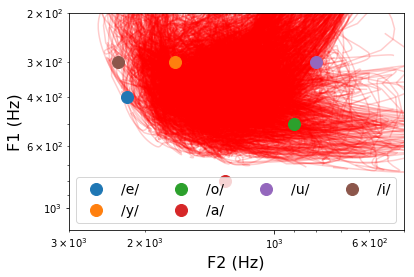

In [12]:
# Parameters to change:
audio = False # If sound is played
iterations = 2000 # Number of iterations
sigma_explo_ratio = 0.05 # Exploration noise (standard deviation)

# Initialization of the sensorimotor model
sm_model = NonParametric(environment.conf, sigma_explo_ratio=sigma_explo_ratio, fwd='NN', inv='NN')

for i in range(iterations):
    if i < 100 or np.random.random() < 0.2: 
        # Do random motor babbling in first 100 iterations and then in 20% of the iterations
        m = environment.random_motors()[0]
    else:
        # Sample a random goal in the sensory space:
        s_goal = rand_bounds(environment.conf.s_bounds)[0]
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm (plus exploration noise):
        m = sm_model.inverse_prediction(s_goal)
        
    s = environment.update(m, audio=audio) # observe the sensory effect s=(x, y): the last position of the ball

    sm_model.update(m, s) # update sensorimotor model
    
    plt.loglog([2.**f[1] for f in environment.formants_traj], [2.**f[0] for f in environment.formants_traj], color="r", alpha=0.2)


# Plot some vowels
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
v_a = list(np.log2([800, 1300]))
vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i, a=v_a)
for v in vowels.keys():
    p = plt.plot(2.**vowels[v][1], 2.**vowels[v][0], "o", label="/" + v + "/", markersize=12)

legend = plt.legend(frameon=True, fontsize=14, ncol=4, loc="lower center")

plt.xlabel("F2 (Hz)", fontsize=16)
plt.ylabel("F1 (Hz)", fontsize=16)
plt.xlim([3000., 500])
plt.ylim([1200., 200.])

We can now look at the sounds that the agent managed to produce. Let's imagine that we want the agent to produce the word /uye/, a sequence of three vowels, /u/, /y/ and /e/. In the following, we define the goal formant trajectory, and ask the agent the best motor parameters it knows to reach this formant trajectory (without adding exploration noise).

Distance to goal /uye/: 0.690090593555


(1200.0, 200.0)

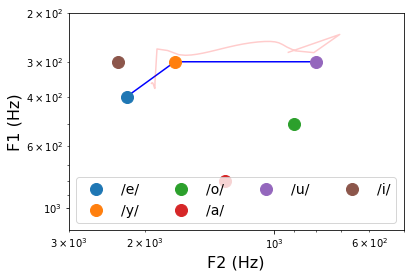

In [13]:
# goal trajectory = /uye/
uye = list(np.linspace(v_u[0], v_y[0], 5)) + list(np.linspace(v_y[0], v_e[0], 5)) + list(np.linspace(v_u[1], v_y[1], 5)) + list(np.linspace(v_y[1], v_e[1], 5))
plt.loglog([2.**f for f in uye[10:]], [2.**f for f in uye[:10]], "b")


# best trajectory for uye
sm_model.mode = "exploit"
m = sm_model.inverse_prediction(uye)
s = environment.update(m)
plt.loglog([2.**f[1] for f in environment.formants_traj], [2.**f[0] for f in environment.formants_traj], color="r", alpha=0.2)

error = np.linalg.norm(np.array(s) - np.array(uye))
print("Distance to goal /uye/:", error)

# Plot some vowels
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
v_a = list(np.log2([800, 1300]))
vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i, a=v_a)
for v in vowels.keys():
    p = plt.plot(2.**vowels[v][1], 2.**vowels[v][0], "o", label="/" + v + "/", markersize=12)

legend = plt.legend(frameon=True, fontsize=14, ncol=4, loc="lower center")

plt.xlabel("F2 (Hz)", fontsize=16)
plt.ylabel("F1 (Hz)", fontsize=16)
plt.xlim([3000., 500])
plt.ylim([1200., 200.])

The target sound trajectory is plotted in blue, and the best trajectory reached by the agent is in red. Note that the agent did not know that it would be tested on that trajectory.

In [14]:
import IPython
IPython.display.Audio(environment.sound_wave(environment.art_traj).flatten(), rate=11025)

## IV. Imitation

In this section, we give a target sound trajectory to the agent so that it tries to imitate it. 
We also run 2000 iterations, where the agent generates random goals for 1000 iteration and then tries to imitate the target sound trajectory /uye/.

In [15]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from explauto.environment.diva import DivaDMPEnvironment
from explauto.sensorimotor_model.non_parametric import NonParametric
from explauto.utils import rand_bounds

diva_cfg = dict(diva_path=os.path.join(os.getenv("HOME"), 'software/DIVAsimulink/'),
                synth="octave",
                m_mins = np.array([-1] * 28),
                m_maxs = np.array([1] * 28),
                s_mins = np.array([7.5]*10 + [9.25]*10),
                s_maxs = np.array([9.5]*10 + [11.25]*10),
                m_used = range(7),
                s_used = range(1, 3),
                n_dmps = 7, # parameters controlled by DMPs
                n_bfs = 2, # basis functions
                dmp_move_steps = 50, # trajectory time steps 
                dmp_max_param = 300., # max value of the weights on basis functions
                sensory_traj_samples = 10, # samples of the formant trajectory to output
                audio = True)

environment = DivaDMPEnvironment(**diva_cfg)

(1200.0, 200.0)

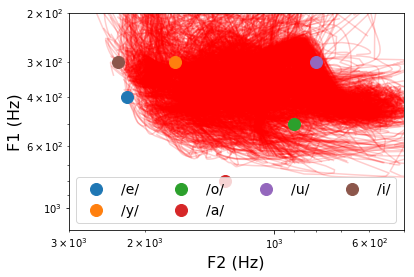

In [16]:
# Parameters to change:
audio = False # If sound is played
iterations = 2000 # Number of iterations
sigma_explo_ratio = 0.05 # Exploration noise (standard deviation)

# Goal to imitate
uye = list(np.linspace(v_u[0], v_y[0], 5)) + list(np.linspace(v_y[0], v_e[0], 5)) + list(np.linspace(v_u[1], v_y[1], 5)) + list(np.linspace(v_y[1], v_e[1], 5))

# Initialization of the sensorimotor model
sm_model = NonParametric(environment.conf, sigma_explo_ratio=sigma_explo_ratio, fwd='NN', inv='NN')

for i in range(iterations):
    if i < 100 or np.random.random() < 0.2: 
        # Do random motor babbling in first 10 iterations and then in 20% of the iterations
        m = environment.random_motors()[0]
    else:
        if i < 1000:
            # Sample a random goal in the sensory space:
            s_goal = rand_bounds(environment.conf.s_bounds)[0]
        else:
            s_goal = uye # Imitates the uye word
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm (plus exploration noise):
        m = sm_model.inverse_prediction(s_goal)
        
    s = environment.update(m, audio=audio) # observe the sensory effect s=(x, y): the last position of the ball

    sm_model.update(m, s) # update sensorimotor model
    
    plt.loglog([2.**f[1] for f in environment.formants_traj], [2.**f[0] for f in environment.formants_traj], color="r", alpha=0.2)


# Plot some vowels
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
v_a = list(np.log2([800, 1300]))
vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i, a=v_a)
for v in vowels.keys():
    p = plt.plot(2.**vowels[v][1], 2.**vowels[v][0], "o", label="/" + v + "/", markersize=12)

legend = plt.legend(frameon=True, fontsize=14, ncol=4, loc="lower center")

plt.xlabel("F2 (Hz)", fontsize=16)
plt.ylabel("F1 (Hz)", fontsize=16)
plt.xlim([3000., 500])
plt.ylim([1200., 200.])

Distance to goal /uye/: 0.359103240436


(1200.0, 200.0)

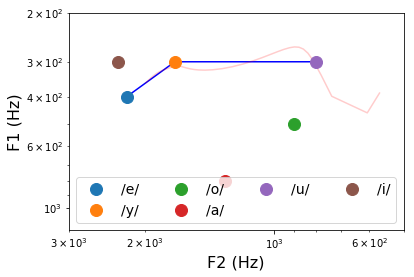

In [17]:
# goal trajectory = /uye/
uye = list(np.linspace(v_u[0], v_y[0], 5)) + list(np.linspace(v_y[0], v_e[0], 5)) + list(np.linspace(v_u[1], v_y[1], 5)) + list(np.linspace(v_y[1], v_e[1], 5))
plt.loglog([2.**f for f in uye[10:]], [2.**f for f in uye[:10]], "b")

# best trajectory for uye
sm_model.mode = "exploit"
m = sm_model.inverse_prediction(uye)
s = environment.update(m)
plt.loglog([2.**f[1] for f in environment.formants_traj], [2.**f[0] for f in environment.formants_traj], color="r", alpha=0.2)

error = np.linalg.norm(np.array(s) - np.array(uye))
print("Distance to goal /uye/:", error)

# Plot some vowels
v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))
v_a = list(np.log2([800, 1300]))
vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i, a=v_a)
for v in vowels.keys():
    p = plt.plot(2.**vowels[v][1], 2.**vowels[v][0], "o", label="/" + v + "/", markersize=12)

legend = plt.legend(frameon=True, fontsize=14, ncol=4, loc="lower center")

plt.xlabel("F2 (Hz)", fontsize=16)
plt.ylabel("F1 (Hz)", fontsize=16)
plt.xlim([3000., 500])
plt.ylim([1200., 200.])

The distance to the target word /uye/ is lower, which means that the agent learned to reproduce the sound trajectory more acurately by focusing on imitating it. However, with goal babbling, the agent also learned reasonable sounds for other words.

In [20]:
import IPython

def say(word):
    v1 = vowels[word[0]]
    v2 = vowels[word[1]]
    v3 = vowels[word[2]]
    traj = list(np.linspace(v1[0], v2[0], 5)) + list(np.linspace(v2[0], v3[0], 5)) + list(np.linspace(v1[1], v2[1], 5)) + list(np.linspace(v2[1], v3[1], 5))

    # best trajectory for uye
    sm_model.mode = "exploit"
    m = sm_model.inverse_prediction(traj)
    s = environment.update(m)
    error = np.linalg.norm(np.array(s) - np.array(traj))
    print("Distance to goal /", word, "/:", error)
    return IPython.display.Audio(environment.sound_wave(environment.art_traj).flatten(), rate=11025)

In [21]:
say("uye")

Distance to goal / uye /: 0.359103240436


In [26]:
say("ieo")

Distance to goal / ieo /: 1.2177647681


In [27]:
say("iee")

Distance to goal / iee /: 0.666645731741


The agent learned to produce the word /uye/ by imitation but also learned to fairly approximates other words autonomously: /ieo/, /iee/.